In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.neural_network import MLPRegressor
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
def split_data(df, size):
    '''
    The spectra are split into a training set and 
    testing set with a ratio of the size_list. The predicted features are the coordination number, 
    number of Cu atoms, and number of Te atoms.
    '''
    
    X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
    list = X.columns.tolist()

    X.columns = range(X.shape[1])
    X.columns = list
   
    y = df[['CN', 'Num Cu', 'Num Te']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=12)
    
    return X_train, X_test, y_train, y_test, X, y


def derivatives(mu_df, dx=0.80808080808):
    '''
    Calculates and returns the first and second derivative of the spectra
    '''

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)-1])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)-2])

    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)-1):
            dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)-2):
            dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx
            
    dmu1_2 = np.concatenate([dmu1, dmu2], axis=1)

    return dmu1, dmu2, dmu1_2

    
def train(X_train, y_train):
    '''
    train_layer trains the neural network. One layer is added, and the depth of the that layer is optimized by 
    looking at the loss from a range of 1 to 100, the maximum number of features being trained on.
    '''
    
    loss = []
    for i in range(100):
        if i == 0:
            pass
        else:
            nn = MLPRegressor(hidden_layer_sizes=(i), activation='identity', solver='lbfgs', max_iter=2000)
            nn = nn.fit(X_train, y_train)
            loss.append(nn.loss_)

    lossdf = pd.DataFrame(loss)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(lossdf)
    return lossdf, nn

def analyse_layer(X_train, X_test, y_train, y_test, nn):
    '''
    analyse_layer returns the training mse and r2 values for the layer in the neural network
    '''
    
    y_train_pred = nn.predict(X_train)
    y_test_pred = nn.predict(X_test)
    train_score_CN = r2_score(y_train.iloc[:,0], y_train_pred[:,0])
    train_score_Cu = r2_score(y_train.iloc[:,1], y_train_pred[:,1]) 
    train_score_Te = r2_score(y_train.iloc[:,2], y_train_pred[:,2])
    test_score_CN = r2_score(y_test.iloc[:,0], y_test_pred[:,0])
    test_score_Cu = r2_score(y_test.iloc[:,1], y_test_pred[:,1])
    test_score_Te = r2_score(y_test.iloc[:,2], y_test_pred[:,2])
    train_mse_CN = mean_squared_error(y_train.iloc[:,0], y_train_pred[:,0])
    train_mse_Cu = mean_squared_error(y_train.iloc[:,1], y_train_pred[:,1])
    train_mse_Te = mean_squared_error(y_train.iloc[:,2], y_train_pred[:,2])
    test_mse_CN = mean_squared_error(y_test.iloc[:,0], y_test_pred[:,0])
    test_mse_Cu = mean_squared_error(y_test.iloc[:,1], y_test_pred[:,1])
    test_mse_Te = mean_squared_error(y_test.iloc[:,2], y_test_pred[:,2])

    train_score_list = [train_score_CN, train_score_Cu, train_score_Te]
    train_mse_list = [train_mse_CN, train_mse_Cu, train_mse_Te]
    test_mse_list = [test_mse_CN, train_mse_Cu, train_mse_Te]
    test_score_list = [test_score_CN, test_score_Cu, test_score_Te]
    print('training mse =  '+ str(train_mse_list))
    print('testing mse = ' + str(test_mse_list))
    print('training R2 = ' + str(train_score_list))
    print('testing R2 = ' + str(test_score_list))
    
    return test_mse_list, test_score_list, y_test_pred

def append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    append_layer_to_list takes the mse and score lists and appends them to a list for plotting erros vs noise, 
    note that here mse is converted to rmse
    '''
    
    rmse_CN = np.sqrt(test_mse_list[0])
    rmse_CN_i_list.append(rmse_CN)
    rmse_Cu = np.sqrt(test_mse_list[1])
    rmse_Cu_i_list.append(rmse_Cu)
    rmse_Te = np.sqrt(test_mse_list[2])
    rmse_Te_i_list.append(rmse_Te)
    
    score_CN = test_score_list[0]
    score_CN_i_list.append(score_CN)
    score_Cu = test_score_list[1]
    score_Cu_i_list.append(score_Cu)
    score_Te = test_score_list[2]
    score_Te_i_list.append(score_Te)

def plot_parity(y_test, y_test_pred):
    '''
    plot_parity is a function to generate parity plots for the layer to check performance for predicting 
    coordination number, number of nearest Te atoms, and number of nearest Cu atoms.
    '''
    x1 = np.linspace(8, 12, 50)
    x2 = np.linspace(4, 8, 50)
    x3 = np.linspace(4, 5, 50)

    plt.figure(figsize=[14,4])
    plt.subplots_adjust(wspace=0.3)
    ax1 = plt.subplot(1,3,1)
    ax1.scatter(y_test.iloc[:,0], y_test_pred[:,0])
    ax1.plot(x1, x1, color='red')
    ax1.set_xlabel('True CN')
    ax1.set_ylabel('Pred CN')
    ax1.set_title('Test CN')
    plt.axis('equal')

    ax2 = plt.subplot(1,3,2)
    ax2.scatter(y_test.iloc[:,1], y_test_pred[:,1])
    ax2.plot(x2, x2, color='red')
    ax2.set_xlabel('True Cu Num')
    ax2.set_ylabel('Pred Cu Num')
    ax2.set_title('Test Cu Num')
    plt.axis('equal')


    ax3 = plt.subplot(1,3,3)
    ax3.scatter(y_test.iloc[:,2], y_test_pred[:,2])
    ax3.plot(x3, x3, color='red')
    ax3.set_xlabel('True Te Num')
    ax3.set_ylabel('Pred Te Num')
    ax3.set_title('Test Te Num')
    plt.axis('equal')
    
    
def run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
              score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    run_layer is a wrapper function that executes the training, testing, analysis, and plotting for a 
    single layer of the neural network
    '''
    lossdf, nn = train(X_train, y_train)
    test_mse_list, test_score_list, y_test_pred = analyse_layer(X_train, X_test, y_train, y_test, nn) #series from dataframe
    append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                         score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    plot_parity(y_test, y_test_pred)

def MLP_per_set_size_spectra(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, 
                     rmse_Te_i_list, score_Te_i_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for spectrum
    '''
    for entry in size_list:
        print('test percent', entry)
        X_train, X_test, y_train, y_test, X, y = split_data(df, entry)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                  score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    print(rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    return rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list

def MLP_per_set_size_1(df, size_list, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, 
                       rmse_Te_i_list_1, score_Te_i_list_1):
    '''
    MLP_per_noise_1 is a wrapper function that runs a layer of neural network per level of noise for the 
    first derivative
    '''
    for entry in size_list:
        print('test percent', entry)
        _, _, _, _, X, y = split_data(df, entry)
        df1, df2, df3 = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df1, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, 
                  score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1)
    print(rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, 
          score_Te_i_list_1)
    return rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1

def MLP_per_set_size_2(df, size_list, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, 
                       rmse_Te_i_list_2, score_Te_i_list_2):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for the second 
    derivative
    '''
    for entry in size_list:
        print('test percent: ', entry)
        _, _, _, _, X, y = split_data(df, entry)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df2, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, 
                  score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2)
    print(rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, 
          score_Te_i_list_2)
    return rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2
    
    
def MLP_per_set_size_1_2(df, size_list, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                         score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for both 
    the first and second derivative
    '''
    for entry in size_list:
        print('test percent: ', entry)
        _, _, _, _, X, y = split_data(df, entry)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df3, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                  score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2)
    print(rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, 
          score_Te_i_list_1_2)
    return rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2

def average_scores_spectra(iterations, df, size_list):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_spectra(iterations, df, size_list)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = size_list)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = size_list)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = size_list)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = size_list)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = size_list)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = size_list)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_spectra = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_spectra
    
def compile_score_lists_spectra(iterations, df, size_list):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_spectra(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1(iterations, df, size_list):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1(iterations, df, size_list)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = size_list)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = size_list)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = size_list)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = size_list)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = size_list)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = size_list)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1
    
def compile_score_lists_1(iterations, df, size_list):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_1(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_2(iterations, df, size_list):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_2(iterations, df, size_list)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = size_list)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = size_list)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = size_list)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = size_list)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = size_list)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = size_list)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_2
    
def compile_score_lists_2(iterations, df, size_list):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_2(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1_2(iterations, df, size_list):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1_2(iterations, df, size_list)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = size_list)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = size_list)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = size_list)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = size_list)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = size_list)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = size_list)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1_2
    
def compile_score_lists_1_2(iterations, df, size_list):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_1_2(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 


Data import of 10,000 calculated average XANES spectra along with averaged coordination numbers, number of Cu atoms within 3 angstroms, and number of Te atoms within 3 angstroms.

In [3]:
df = pd.read_csv('mu_cn1000_energies.csv')

# Train on spectra Only:

Create dataframes for plotting noise vs R2 and RMSE

In [4]:
size_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
iterations = 20

In [5]:
size_list = [0.9]
iterations = 2

test percent 0.9
           0
0   0.018811
1   0.001346
2   0.001799
3   0.001333
4   0.001397
5   0.001530
6   0.001493
7   0.001974
8   0.001448
9   0.001392
10  0.001953
11  0.001411
12  0.001957
13  0.001933
14  0.001389
15  0.001917
16  0.001340
17  0.001341
18  0.001967
19  0.001347
20  0.001861
21  0.001938
22  0.001346
23  0.002008
24  0.001960
25  0.001802
26  0.001351
27  0.001915
28  0.001304
29  0.001356
30  0.001879
31  0.001354
32  0.001921
33  0.001918
34  0.001527
35  0.001714
36  0.001720
37  0.001404
38  0.001782
39  0.001428
40  0.001390
41  0.001883
42  0.001339
43  0.001547
44  0.002017
45  0.001503
46  0.001405
47  0.001525
48  0.001643
49  0.001473
50  0.001839
51  0.001391
52  0.001552
53  0.001780
54  0.001951
55  0.001930
56  0.001992
57  0.001739
58  0.001954
59  0.001971
60  0.001371
61  0.001928
62  0.003671
63  0.001586
64  0.001516
65  0.001812
66  0.001697
67  0.001992
68  0.001954
69  0.001388
70  0.001970
71  0.001963
72  0.001745
73  0.001932
74  0.00

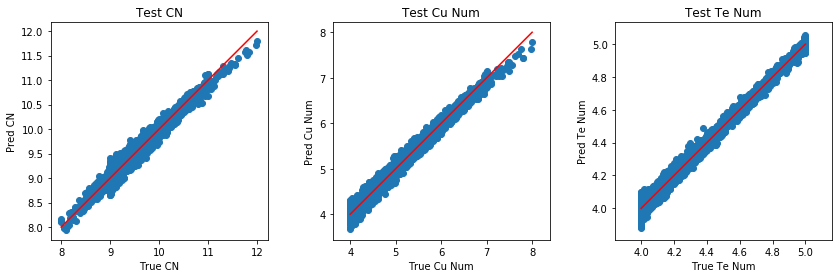

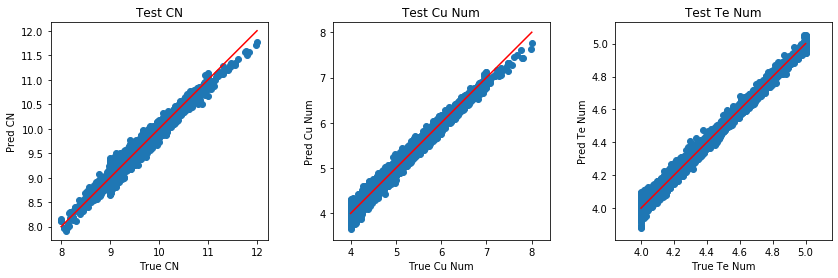

In [6]:
results_df_spectra = average_scores_spectra(iterations, df, size_list)

# Train with first derivative:

test percent 0.9
           0
0   0.007448
1   0.000340
2   0.000442
3   0.000275
4   0.000335
5   0.000294
6   0.000260
7   0.000287
8   0.000310
9   0.000282
10  0.000361
11  0.000303
12  0.000289
13  0.000326
14  0.000282
15  0.000375
16  0.000360
17  0.000318
18  0.000292
19  0.000540
20  0.000302
21  0.000293
22  0.000370
23  0.000297
24  0.000420
25  0.000329
26  0.000298
27  0.000357
28  0.000335
29  0.000307
30  0.000308
31  0.000306
32  0.000289
33  0.000311
34  0.000298
35  0.000333
36  0.000296
37  0.000322
38  0.000348
39  0.000384
40  0.000468
41  0.000372
42  0.000364
43  0.000427
44  0.000433
45  0.000543
46  0.000354
47  0.000315
48  0.000375
49  0.000289
50  0.000381
51  0.000371
52  0.000737
53  0.000501
54  0.000384
55  0.000398
56  0.000381
57  0.000357
58  0.000510
59  0.000436
60  0.000597
61  0.000390
62  0.000392
63  0.000317
64  0.000352
65  0.000366
66  0.000366
67  0.000395
68  0.000502
69  0.000337
70  0.000311
71  0.000384
72  0.000476
73  0.000362
74  0.00

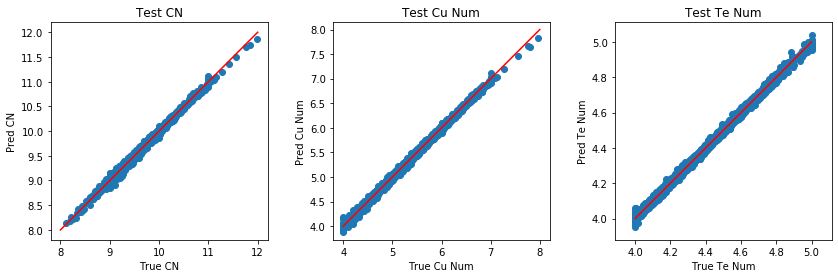

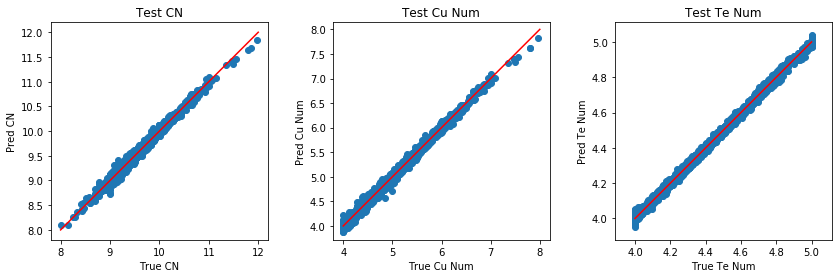

In [7]:
results_df_1 = average_scores_1(iterations, df, size_list)

# Training with second derivative:

test percent:  0.9
           0
0   0.007987
1   0.002280
2   0.000330
3   0.000402
4   0.000366
5   0.000315
6   0.000395
7   0.000495
8   0.000439
9   0.000473
10  0.000499
11  0.000779
12  0.000469
13  0.000454
14  0.000316
15  0.000548
16  0.000485
17  0.000458
18  0.000487
19  0.000467
20  0.000392
21  0.000502
22  0.000498
23  0.000489
24  0.000503
25  0.000461
26  0.000541
27  0.000554
28  0.000448
29  0.000462
30  0.000556
31  0.000526
32  0.000500
33  0.000451
34  0.000526
35  0.000492
36  0.000490
37  0.000469
38  0.000524
39  0.000450
40  0.000512
41  0.000520
42  0.000460
43  0.000519
44  0.000429
45  0.000510
46  0.000548
47  0.000556
48  0.000557
49  0.000498
50  0.000578
51  0.000468
52  0.000632
53  0.000663
54  0.000492
55  0.000498
56  0.001622
57  0.000525
58  0.000548
59  0.000544
60  0.000481
61  0.000528
62  0.000522
63  0.000563
64  0.000588
65  0.000498
66  0.000598
67  0.000521
68  0.000542
69  0.000504
70  0.000864
71  0.000479
72  0.000542
73  0.000591
74  0.

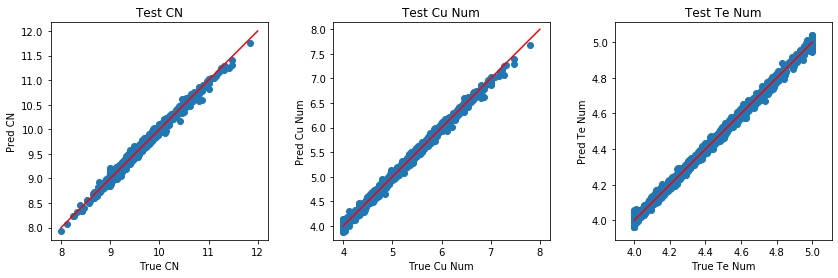

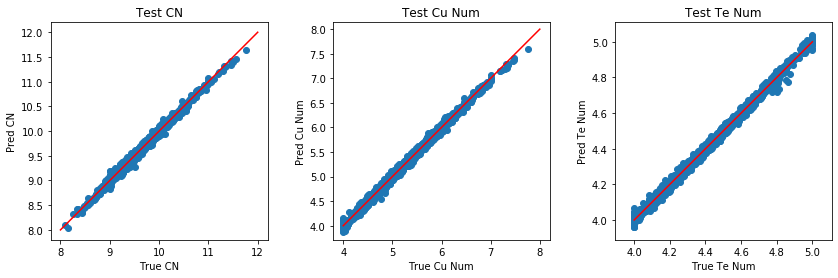

In [8]:
results_df_2 = average_scores_2(iterations, df, size_list)

# Train with both the first and second derivative:

test percent:  0.9
           0
0   0.007362
1   0.000328
2   0.000248
3   0.000253
4   0.000260
5   0.000253
6   0.000285
7   0.000320
8   0.000517
9   0.000252
10  0.000338
11  0.000240
12  0.000260
13  0.000281
14  0.000298
15  0.000265
16  0.000257
17  0.000290
18  0.000342
19  0.000267
20  0.000286
21  0.000347
22  0.000333
23  0.000412
24  0.000280
25  0.000262
26  0.000338
27  0.000344
28  0.000382
29  0.000318
30  0.000383
31  0.000300
32  0.000321
33  0.000310
34  0.000270
35  0.000347
36  0.000310
37  0.000297
38  0.000324
39  0.000315
40  0.000268
41  0.000348
42  0.000317
43  0.000449
44  0.000300
45  0.000285
46  0.000531
47  0.000317
48  0.000407
49  0.000336
50  0.000414
51  0.000337
52  0.000330
53  0.000383
54  0.000325
55  0.000274
56  0.000316
57  0.000321
58  0.000415
59  0.000378
60  0.000433
61  0.000345
62  0.000335
63  0.000411
64  0.000309
65  0.000308
66  0.000403
67  0.000364
68  0.000325
69  0.000527
70  0.000342
71  0.000323
72  0.000418
73  0.000345
74  0.

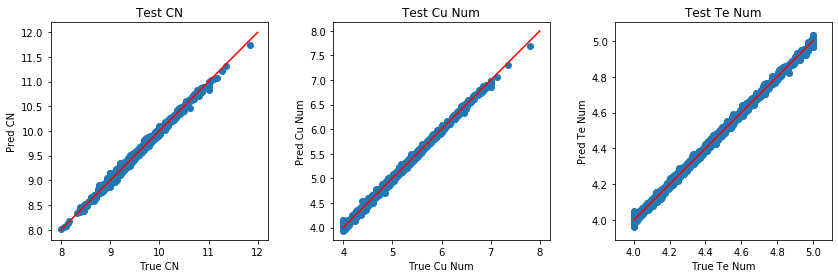

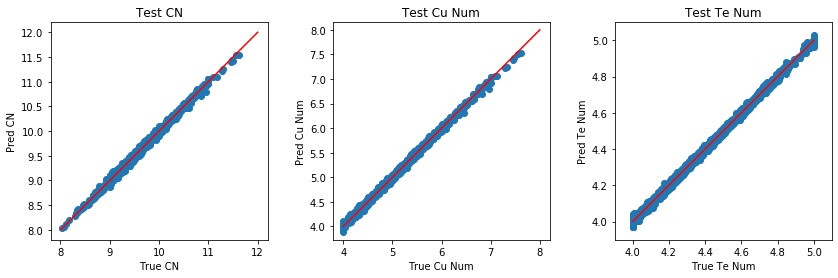

In [9]:
results_df_1_2 = average_scores_1_2(iterations, df, size_list)

# Plot the error for predicting coordination number:

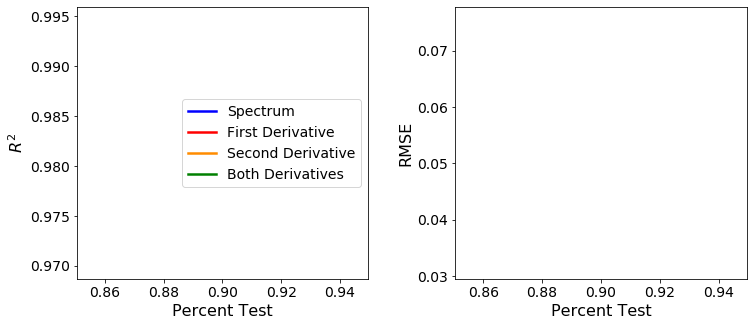

In [10]:

plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_CN'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_CN'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_CN'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_CN'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Percent Test', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_CN'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_CN'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_CN'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_CN'], c='green', lw=2.5)
ax2.set_xlabel('Percent Test', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

# Plot the error for predicting number of nearest Cu:

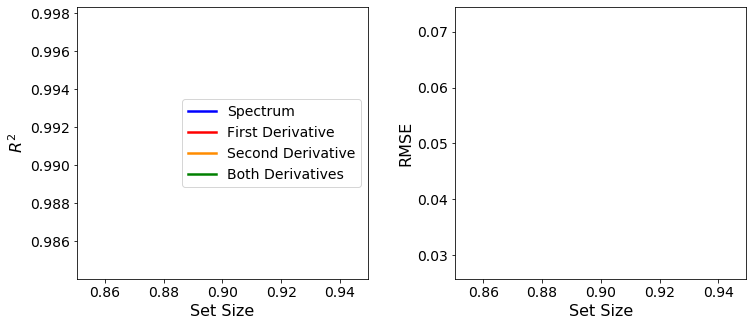

In [11]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_Cu'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_Cu'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_Cu'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_Cu'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_Cu'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_Cu'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_Cu'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_Cu'], c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

# Plot the error for predicting number of nearest Te

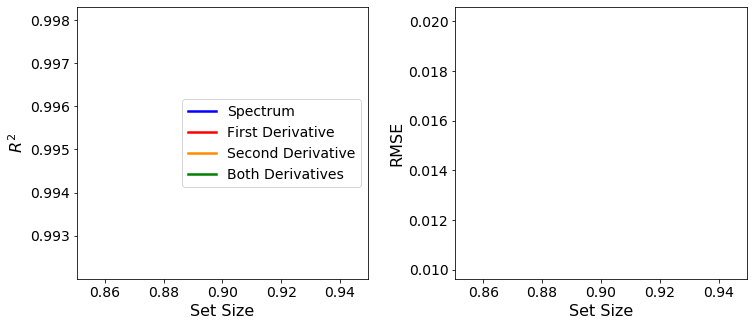

In [12]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_Te'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_Te'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_Te'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_Te'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_Te'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_Te'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_Te'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_Te'], c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()